In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from sklearn.linear_model import Ridge

In [3]:
wedf = pd.read_csv('/kaggle/input/delhi-weather-data/testset.csv')
wedf.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [4]:
wedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 non-null  int64  
 11   _tempm       100317 non-null  float64
 12   _thunder     100990 non-null  int64  
 13   _tornado     100990 non-null  int64  
 14   _vism        96562 non-null   float64
 15   _wdird       86235 non-null   float64
 16   _wdire       86235 non-null   object 
 17   _wgustm      1072 non-null    float64
 18   _wi

In [5]:
wedf.describe()

,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wgustm,_windchillm,_wspdm
count,100369.000000,100990.000000,100990.000000,29155.000000,100233.000000,0.0,1.007580e+05,100990.000000,100990.000000,100317.000000,100990.000000,100990.00000,96562.000000,86235.000000,1072.000000,579.000000,98632.000000
mean,15.741205,0.069690,0.000129,35.651710,57.909481,NaN,1.932331e+03,0.026260,0.000010,25.451269,0.009427,0.00002,2.402774,163.549974,37.671175,5.713817,7.678463
std,7.058587,0.254625,0.011345,5.015384,23.807771,NaN,3.183786e+05,0.159908,0.003147,8.482859,0.096633,0.00445,20.746028,120.002076,6.848666,1.203290,11.932157
min,-24.000000,0.000000,0.000000,26.800000,4.000000,NaN,-9.999000e+03,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,25.900000,2.100000,0.000000
25%,10.000000,0.000000,0.000000,31.700000,39.000000,NaN,1.002000e+03,0.000000,0.000000,19.000000,0.000000,0.00000,1.500000,50.000000,33.300000,4.900000,0.000000
50%,15.000000,0.000000,0.000000,35.100000,59.000000,NaN,1.008000e+03,0.000000,0.000000,27.000000,0.000000,0.00000,2.000000,160.000000,37.000000,6.100000,7.400000
75%,22.000000,0.000000,0.000000,39.200000,78.000000,NaN,1.014000e+03,0.000000,0.000000,32.000000,0.000000,0.00000,3.000000,270.000000,40.700000,6.800000,11.100000
max,75.000000,1.000000,1.000000,73.600000,243.000000,NaN,1.010614e+08,1.000000,1.000000,90.000000,1.000000,1.00000,6436.000000,960.000000,92.600000,7.300000,1514.900000


In [6]:
wedf.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object')

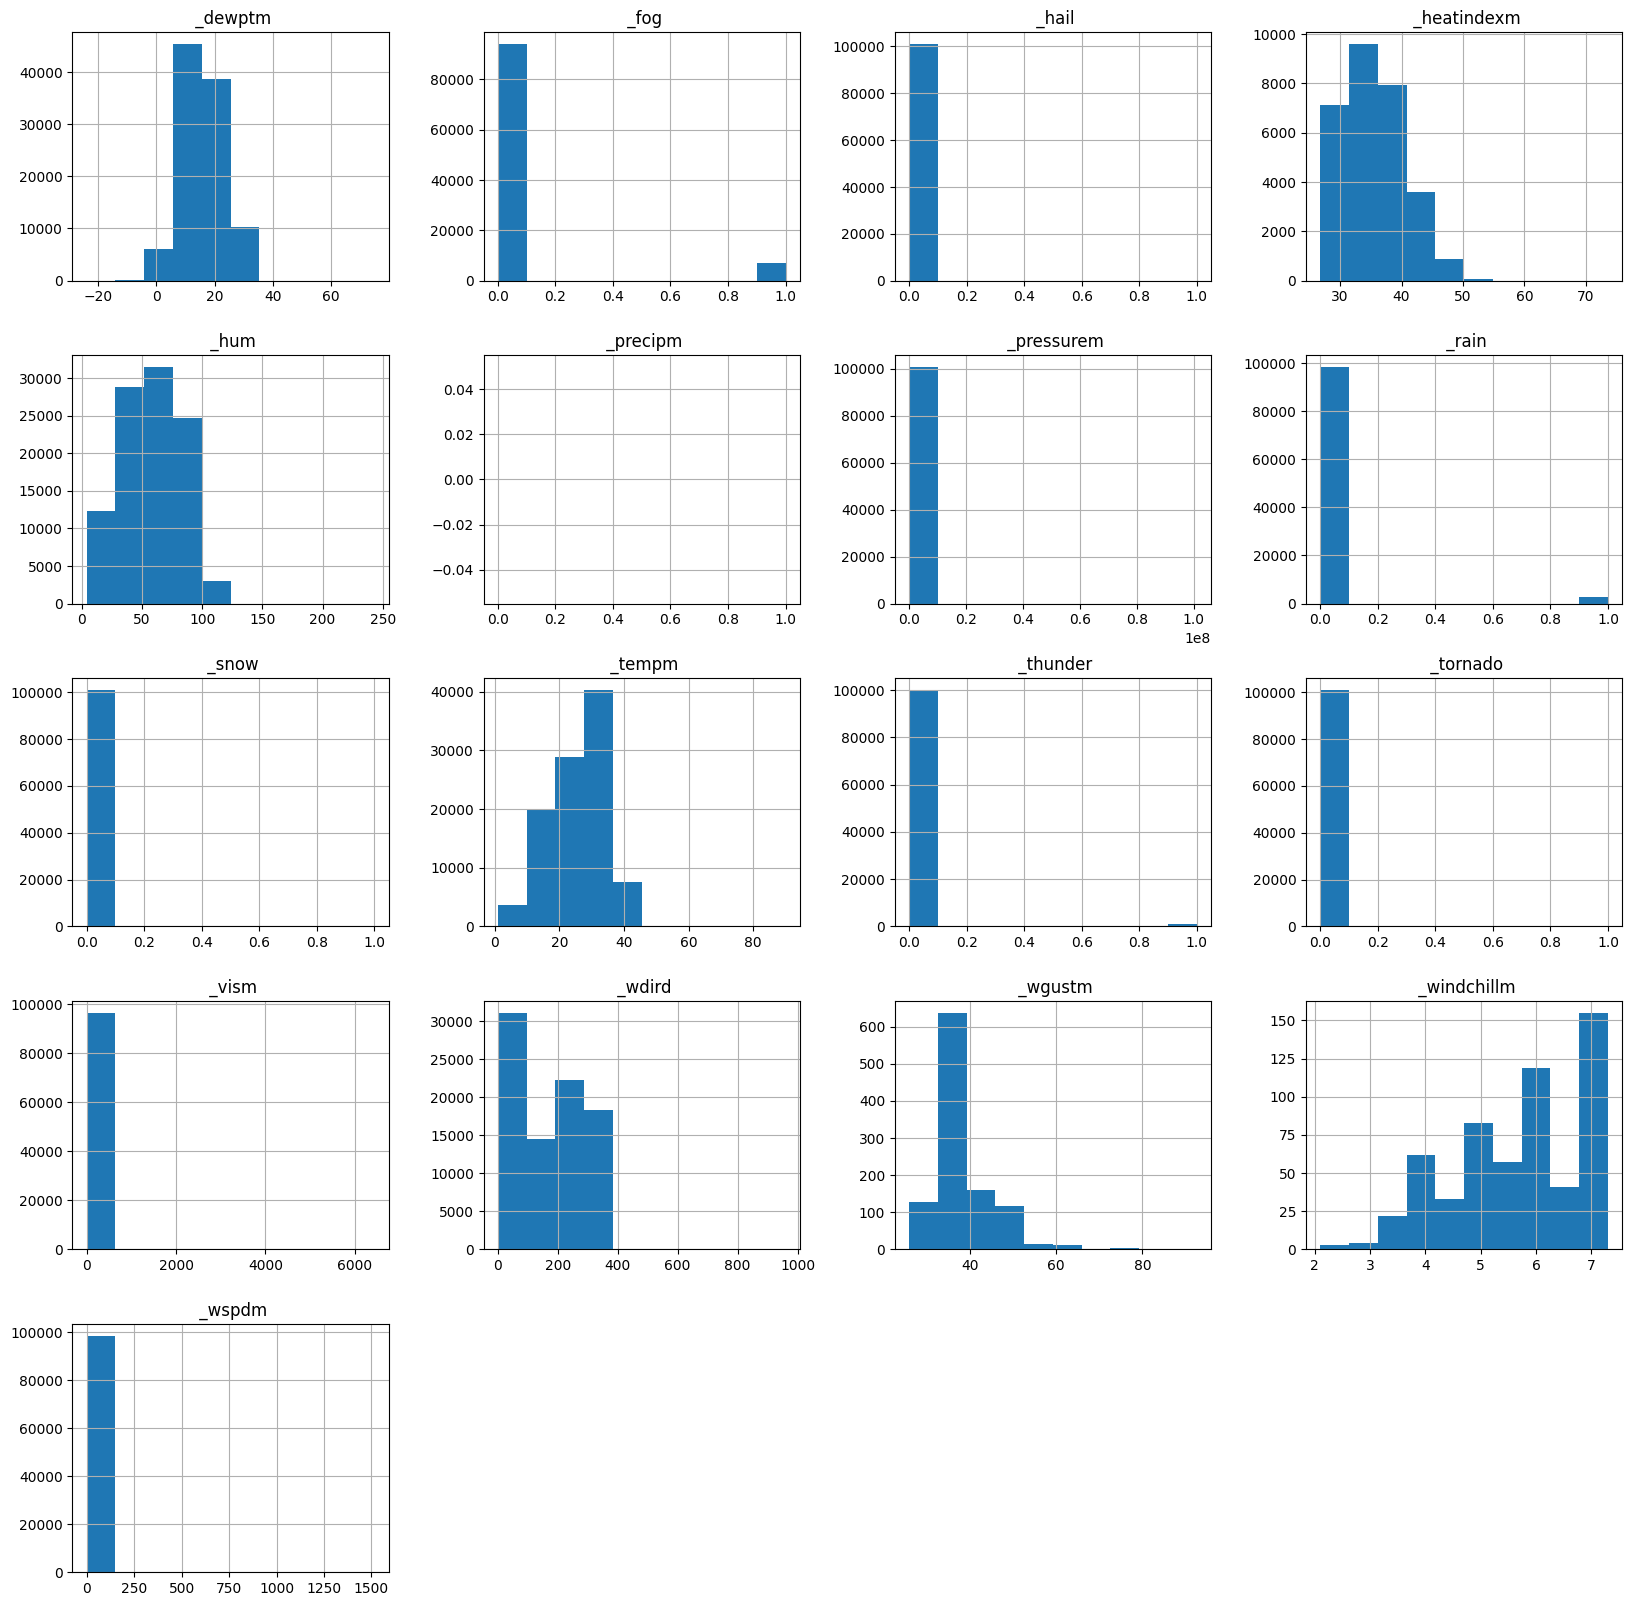

In [7]:
wedf.hist(figsize=(20,20))
plt.show()

In [8]:
wedf[' _conds'].value_counts()

 _conds
Haze                             47602
Smoke                            20760
Mist                              9375
Clear                             3129
Widespread Dust                   2856
Fog                               2760
Scattered Clouds                  2209
Partly Cloudy                     2091
Shallow Fog                       1860
Mostly Cloudy                     1537
Light Rain                        1302
Partial Fog                       1031
Patches of Fog                     901
Thunderstorms and Rain             486
Heavy Fog                          421
Light Drizzle                      414
Rain                               394
Unknown                            383
Blowing Sand                       378
Overcast                           326
Thunderstorm                       192
Light Thunderstorms and Rain       176
Drizzle                            112
Light Fog                           64
Light Thunderstorm                  64
Heavy Rain       

In [9]:
wedf.groupby(' _conds')[' _wspdm'].mean()

 _conds
Blowing Sand                     24.499471
Clear                            11.189686
Drizzle                           8.846364
Fog                               3.889359
Funnel Cloud                     10.200000
Haze                              8.793094
Heavy Fog                         3.330404
Heavy Rain                       16.396429
Heavy Thunderstorms and Rain     15.168182
Heavy Thunderstorms with Hail    18.500000
Light Drizzle                     8.059512
Light Fog                         2.671875
Light Freezing Rain              14.800000
Light Hail Showers               11.100000
Light Haze                       20.350000
Light Rain                        8.748560
Light Rain Showers               18.140000
Light Sandstorm                  36.416667
Light Thunderstorm                6.342187
Light Thunderstorms and Rain     14.288304
Mist                              2.732397
Mostly Cloudy                     8.947106
Overcast                          9.568571
Par

In [10]:
wedf.groupby(' _conds')[' _tempm'].mean()

 _conds
Blowing Sand                     34.936340
Clear                            27.211508
Drizzle                          25.018182
Fog                              10.240659
Funnel Cloud                     28.000000
Haze                             29.250549
Heavy Fog                        10.475059
Heavy Rain                       23.464286
Heavy Thunderstorms and Rain     24.200000
Heavy Thunderstorms with Hail    15.000000
Light Drizzle                    24.804878
Light Fog                        12.698413
Light Freezing Rain                    NaN
Light Hail Showers               14.000000
Light Haze                       28.000000
Light Rain                       25.576389
Light Rain Showers               27.800000
Light Sandstorm                  33.333333
Light Thunderstorm               27.656250
Light Thunderstorms and Rain     24.000000
Mist                             19.493425
Mostly Cloudy                    25.906658
Overcast                         21.916667
Par

In [11]:
null_pct_col = wedf.apply(pd.isnull).sum()/wedf.shape[0]
print(null_pct_col)

datetime_utc    0.000000
 _conds         0.000713
 _dewptm        0.006149
 _fog           0.000000
 _hail          0.000000
 _heatindexm    0.711308
 _hum           0.007496
 _precipm       1.000000
 _pressurem     0.002297
 _rain          0.000000
 _snow          0.000000
 _tempm         0.006664
 _thunder       0.000000
 _tornado       0.000000
 _vism          0.043846
 _wdird         0.146104
 _wdire         0.146104
 _wgustm        0.989385
 _windchillm    0.994267
 _wspdm         0.023349
dtype: float64


In [12]:
wedf_vcol = wedf.columns[null_pct_col<.05] 
print(wedf_vcol)

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail', ' _hum',
       ' _pressurem', ' _rain', ' _snow', ' _tempm', ' _thunder', ' _tornado',
       ' _vism', ' _wspdm'],
      dtype='object')


In [13]:
dfc = wedf[wedf_vcol]
dfc = dfc.set_index(pd.to_datetime(dfc['datetime_utc']))
dfc = dfc.drop(['datetime_utc',' _fog', ' _hail',' _rain', ' _snow', 
                ' _thunder', ' _tornado',' _wspdm',' _vism'],axis=1)

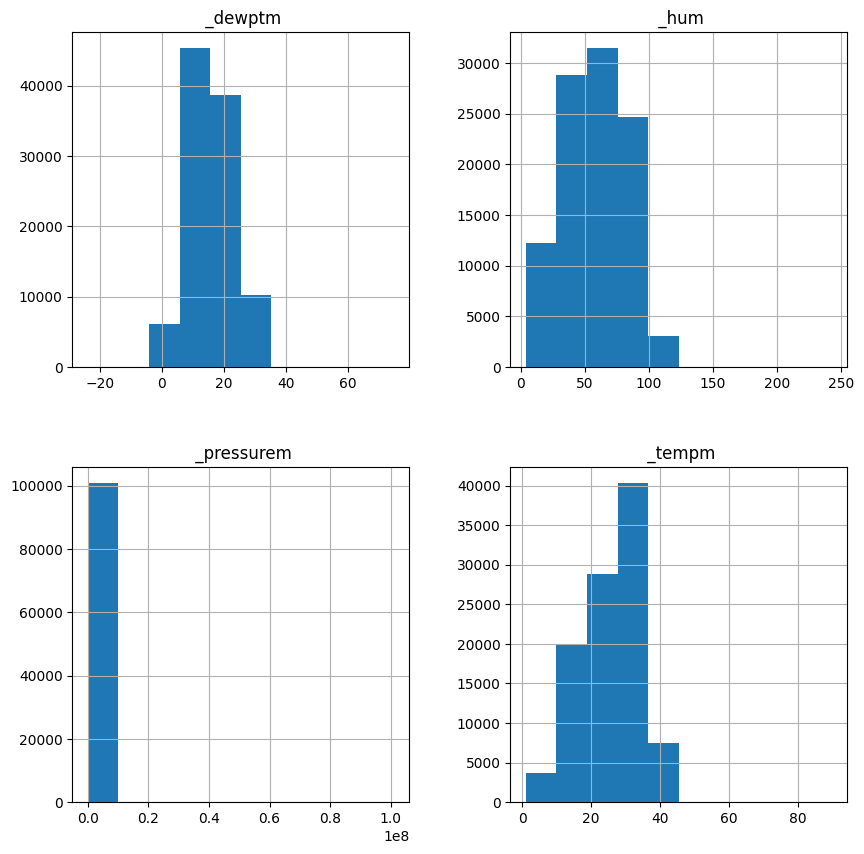

In [14]:
dfc.hist(figsize=(10,10))
plt.show()

In [15]:
 dfc = dfc.rename(columns={' _conds': 'condition', ' _hum': 'humidity',
                           ' _tempm': 'temperature', ' _pressurem':'pressure',
                           ' _dewptm':'dew_temp' })       

In [16]:
print(dfc.head())
print(dfc.columns)

                    condition  dew_temp  humidity  pressure  temperature
datetime_utc                                                            
1996-11-01 11:00:00     Smoke       9.0      27.0    1010.0         30.0
1996-11-01 12:00:00     Smoke      10.0      32.0   -9999.0         28.0
1996-11-01 13:00:00     Smoke      11.0      44.0   -9999.0         24.0
1996-11-01 14:00:00     Smoke      10.0      41.0    1010.0         24.0
1996-11-01 16:00:00     Smoke      11.0      47.0    1011.0         23.0
Index(['condition', 'dew_temp', 'humidity', 'pressure', 'temperature'], dtype='object')


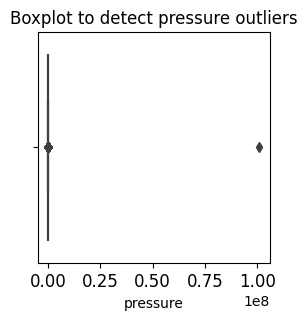

In [17]:
plt.figure(figsize=(3,3))
plt.title('Boxplot to detect pressure outliers', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=dfc['pressure'])
plt.show()

In [18]:
percentile25 = dfc['pressure'].quantile(0.25)

percentile75 = dfc['pressure'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)
outliers = dfc[(dfc['pressure'] > upper_limit) | (dfc['pressure'] < lower_limit)]
print("Number of rows in the data containing outliers in `Pressure`:", len(outliers))

dfc.loc[dfc['pressure']>upper_limit ,'pressure'] = upper_limit
dfc.loc[dfc['pressure']<lower_limit, 'pressure'] = lower_limit

outliers = dfc[(dfc['pressure'] > upper_limit) | (dfc['pressure'] < lower_limit)]

print("Number of rows in the data containing outliers in `Pressure`:", len(outliers))

Lower limit: 984.0
Upper limit: 1032.0
Number of rows in the data containing outliers in `Pressure`: 925
Number of rows in the data containing outliers in `Pressure`: 0


<Axes: xlabel='datetime_utc'>

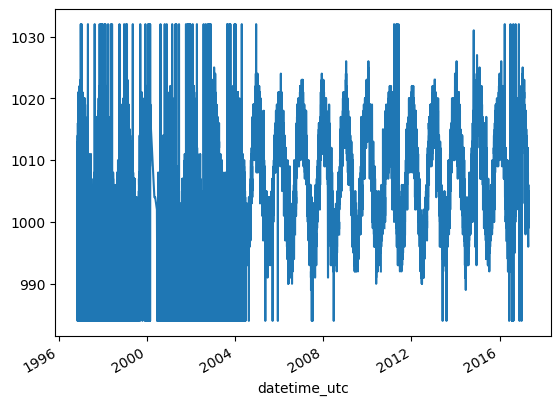

In [19]:
dfc['pressure'].plot()

In [20]:
dfc['pressure'].value_counts().sort_index()

pressure
984.0      854
988.0        1
989.0        2
990.0       31
991.0       64
992.0      156
993.0      276
994.0      710
995.0     1186
996.0     1925
997.0     2690
998.0     3681
999.0     3882
1000.0    4502
1001.0    4325
1002.0    4614
1003.0    4031
1004.0    4268
1005.0    3787
1006.0    3524
1007.0    3142
1008.0    3473
1009.0    3331
1010.0    3740
1011.0    3890
1012.0    4443
1013.0    4436
1014.0    5371
1015.0    5137
1016.0    5206
1017.0    4018
1018.0    3549
1019.0    2607
1020.0    1959
1021.0    1096
1022.0     513
1023.0     189
1024.0      58
1025.0      14
1026.0       4
1027.0       1
1031.0       1
1032.0      71
Name: count, dtype: int64

In [21]:
dfc.groupby('temperature')['pressure'].mean()

temperature
1.0     1020.000000
3.0     1019.000000
4.0     1017.808511
5.0     1017.737113
6.0     1017.622642
7.0     1017.698241
8.0     1017.643585
9.0     1017.403832
10.0    1017.106542
11.0    1016.611370
12.0    1016.340099
13.0    1015.711168
14.0    1015.450334
15.0    1015.324451
16.0    1014.961674
17.0    1014.659651
18.0    1014.371641
19.0    1013.936114
20.0    1013.567224
21.0    1013.135777
22.0    1012.514672
23.0    1011.946474
24.0    1010.880795
25.0    1009.389648
26.0    1007.387671
27.0    1005.717491
28.0    1004.449946
29.0    1003.850774
30.0    1003.507426
31.0    1003.281293
32.0    1002.956822
33.0    1002.812557
34.0    1002.413090
35.0    1001.704677
36.0    1001.249350
37.0    1000.964355
38.0    1000.814426
39.0    1000.285356
40.0     999.806034
41.0     999.119013
42.0     998.748538
43.0     997.750000
44.0     997.013699
45.0     997.329787
46.0     998.148148
47.0     996.538462
62.0    1018.000000
63.0     995.000000
72.0    1015.000000
90.0    

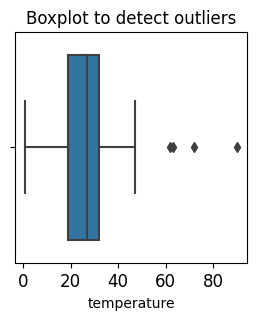

In [22]:
plt.figure(figsize=(3,3))
plt.title('Boxplot to detect outliers', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=dfc['temperature'])
plt.show()

In [23]:
percentile25 = dfc['temperature'].quantile(0.25)

percentile75 = dfc['temperature'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

outliers = dfc[(dfc['temperature'] > upper_limit)]
print("Number of rows in the data containing outliers in `Temperature`:", len(outliers))

dfc.loc[dfc['temperature']>upper_limit ,'temperature'] = upper_limit

outliers = dfc[(dfc['temperature'] > upper_limit)]

print("Number of rows in the data containing outliers in `Temperature`:", len(outliers))

Lower limit: -0.5
Upper limit: 51.5
Number of rows in the data containing outliers in `Temperature`: 4
Number of rows in the data containing outliers in `Temperature`: 0


<Axes: xlabel='datetime_utc'>

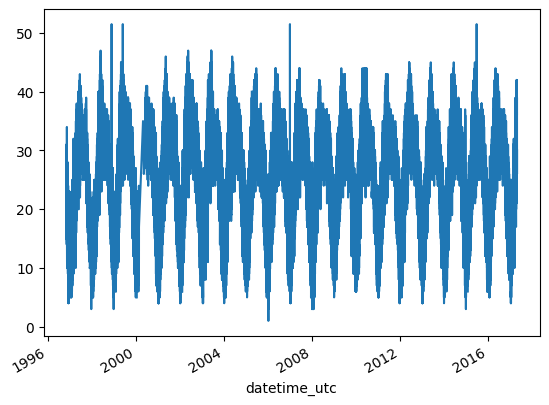

In [24]:
dfc['temperature'].plot()

In [25]:
dfc.isnull().sum()

condition       72
dew_temp       621
humidity       757
pressure       232
temperature    673
dtype: int64

In [26]:
dfc = dfc.ffill()

In [27]:
dfc.dtypes

condition       object
dew_temp       float64
humidity       float64
pressure       float64
temperature    float64
dtype: object

In [28]:
dfc.index.year.value_counts().sort_index()

datetime_utc
1996     1278
1997     6513
1998     3579
1999     6300
2000     5391
2001     8403
2002     8503
2003    13186
2004     9151
2005     2920
2006     2858
2007     2865
2008     2857
2009     2851
2010     2768
2011     2738
2012     2438
2013     2428
2014     2973
2015     2936
2016     6634
2017     1420
Name: count, dtype: int64

<Axes: title={'center': 'Delhi Weather Condition'}, xlabel='condition', ylabel='count'>

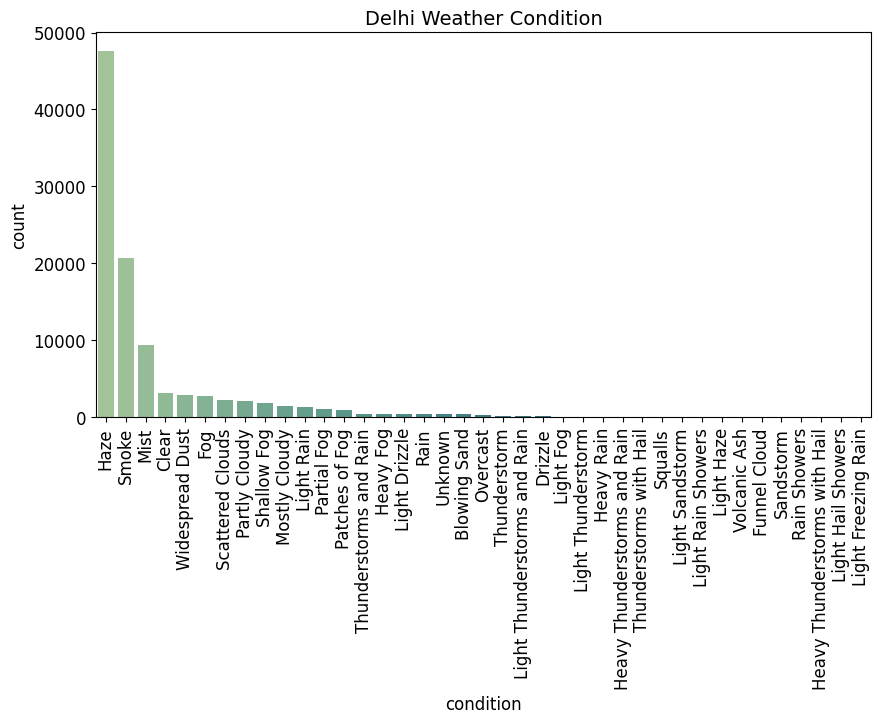

In [29]:
plt.figure(figsize=(10,5))
plt.title('Delhi Weather Condition', fontsize=14)
plt.xlabel("Weather", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
sns.countplot(x = "condition", data = dfc, palette='crest', order=dfc["condition"].value_counts().index)

## Time Series Analysis

In [30]:
wa_df = dfc.copy()
wa_df = wa_df.drop(['temperature','condition'],axis=1, errors = 'ignore')
wa_df = wa_df.resample('D').mean()

tempdf = dfc.resample('D').agg({'temperature': ['min', 'max']})
tempdf.columns = ['min_temperature','max_temperature']

wa_df = wa_df.join(tempdf)
wa_df['target_temperature'] = wa_df.shift(-1)['max_temperature']

print(wa_df.tail())

wa_df = wa_df.ffill()



               dew_temp   humidity     pressure  min_temperature  \
datetime_utc                                                       
2017-04-20    16.750000  27.500000   998.625000             27.0   
2017-04-21    21.500000  39.375000   999.875000             30.0   
2017-04-22    20.400000  40.900000  1001.600000             28.0   
2017-04-23    15.125000  27.500000  1002.125000             27.0   
2017-04-24    14.857143  27.142857  1004.142857             26.0   

              max_temperature  target_temperature  
datetime_utc                                       
2017-04-20               42.0                39.0  
2017-04-21               39.0                38.0  
2017-04-22               38.0                39.0  
2017-04-23               39.0                38.0  
2017-04-24               38.0                 NaN  


In [31]:
wa_df.corr()

,dew_temp,humidity,pressure,min_temperature,max_temperature,target_temperature
dew_temp,1.000000,0.296133,-0.744339,0.791496,0.553121,0.543413
humidity,0.296133,1.000000,0.212911,-0.281177,-0.578393,-0.545126
pressure,-0.744339,0.212911,1.000000,-0.896352,-0.783409,-0.766501
min_temperature,0.791496,-0.281177,-0.896352,1.000000,0.873415,0.856042
max_temperature,0.553121,-0.578393,-0.783409,0.873415,1.000000,0.940859
target_temperature,0.543413,-0.545126,-0.766501,0.856042,0.940859,1.000000


#### Ridge Regression

In [32]:
x = wa_df.columns[~wa_df.columns.isin(["target_temperature"])]
Ridge_reg = Ridge(alpha=.1)

In [33]:
def step_pred(df, model, predictors, start=1095, step=30):
    all_predictions = []
    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["target_temperature"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target_temperature"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [34]:
predictions = step_pred(wa_df, Ridge_reg, x)

In [35]:
print('Mean_Squared_Error:',mean_squared_error(predictions["actual"], predictions["prediction"]))
print('Mean_Absolute_error:',mean_absolute_error(predictions["actual"], predictions["prediction"]))

Mean_Squared_Error: 5.225559522042771
Mean_Absolute_error: 1.639145956976138


In [36]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
datetime_utc,,,
2006-12-31,14.0,44.445246,30.445246
2006-12-30,51.5,21.615933,29.884067
2015-06-24,30.0,46.253774,16.253774
2015-06-23,51.5,38.187826,13.312174
2014-12-16,19.0,32.103573,13.103573
...,...,...,...
2015-09-21,35.0,34.997718,0.002282
2016-12-26,23.0,23.001915,0.001915
2013-10-24,29.0,28.998937,0.001063


#### ARIMA


In [37]:
wea_df = dfc[['temperature']].copy()
wea_df.head()

,temperature
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 16:00:00,23.0


In [38]:
wea_df = wea_df.resample('D').mean().round()
print(wea_df.isna().sum())
print()
wea_df.fillna(wea_df['temperature'].mean(), inplace=True)
print(wea_df.isna().sum())

temperature    141
dtype: int64

temperature    0
dtype: int64


In [39]:
wea_df.head()

,temperature
datetime_utc,
1996-11-01,22.0
1996-11-02,23.0
1996-11-03,22.0
1996-11-04,23.0
1996-11-05,28.0


In [40]:
wea_df.index.year.value_counts().sort_index()

datetime_utc
1996     61
1997    365
1998    365
1999    365
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    114
Name: count, dtype: int64

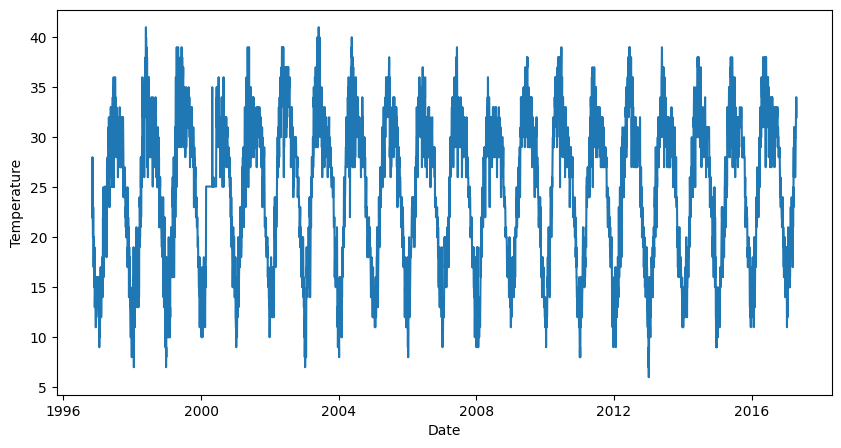

In [41]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(wea_df)

In [42]:
model = ARIMA(wea_df, order=(1,0,1))
results_ARIMA = model.fit()

ARIMA model


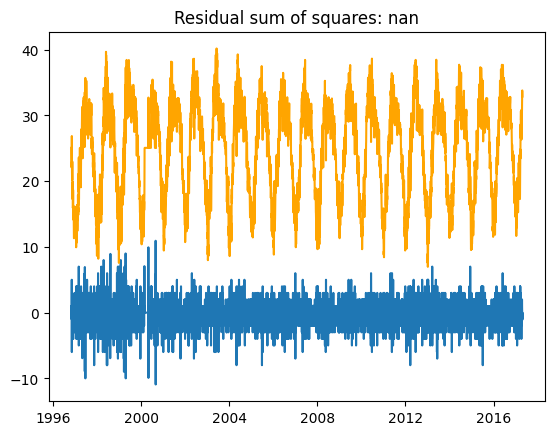

In [43]:
plt.plot(wea_df.diff())
plt.plot(results_ARIMA.fittedvalues, color='orange')
plt.title('Residual sum of squares: %.4f'%sum((results_ARIMA.fittedvalues - wea_df.diff()['temperature'])**2))
print('ARIMA model')

In [44]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())
print(predictions_ARIMA_diff.shape)

datetime_utc
1996-11-01    25.072613
1996-11-02    22.090013
1996-11-03    22.851069
1996-11-04    22.234227
1996-11-05    22.873809
Freq: D, dtype: float64
(7480,)


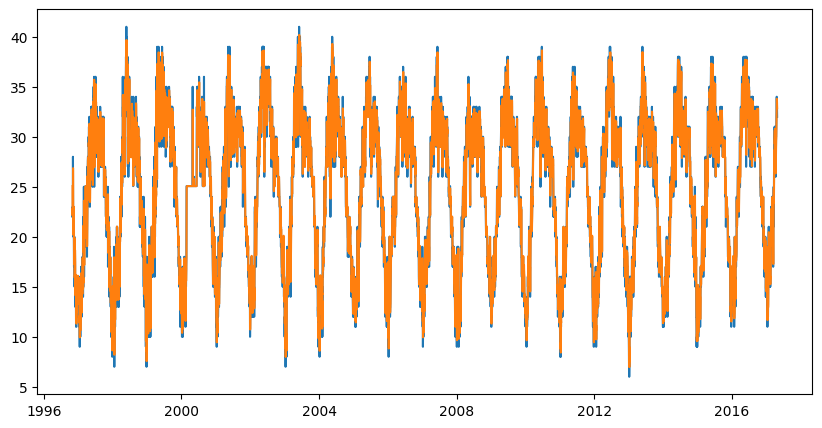

In [45]:
plt.figure(figsize=(10,5))
plt.plot(wea_df)
plt.plot(predictions_ARIMA_diff)

#### BiLSTM

In [46]:
wels_df = wea_df.copy()
wels_df = wels_df.values 
wels_df = wels_df.reshape(-1,1)

print(wels_df)

[[22.]
 [23.]
 [22.]
 ...
 [33.]
 [33.]
 [32.]]


In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(wels_df)

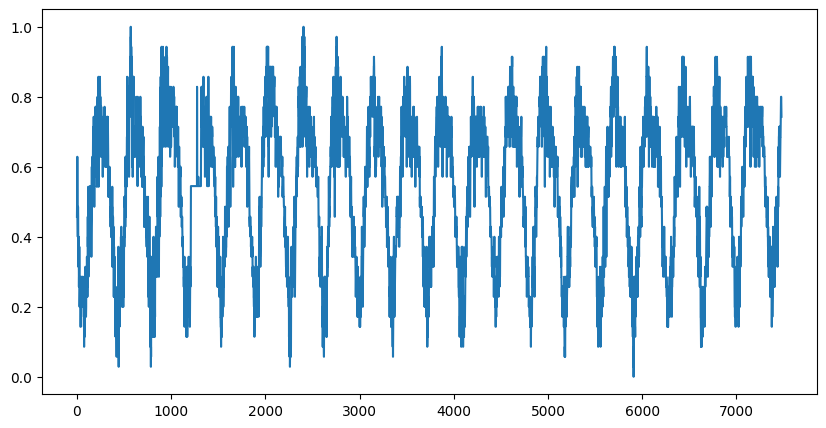

In [48]:
plt.figure(figsize=(10,5))
plt.plot(data_scaled)

In [49]:
training_size=int(len(data_scaled)*0.75)
test_size=len(data_scaled)-training_size
train_data,test_data=data_scaled[0:training_size,:],data_scaled[training_size:len(data_scaled),:1]

In [50]:
training_size,test_size

(5610, 1870)

In [51]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]           
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [52]:
time_step = 64
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [53]:
print(X_train.shape ,y_train.shape)

(5545, 64) (5545,)


In [54]:
print(X_test.shape, ytest.shape)

(1805, 64) (1805,)


In [55]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [56]:
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(64,1)))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation ='linear'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,049 (461.13 KB)

 Trainable params: 118,049 (461.13 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.001),
             metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError()])

In [58]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=5,batch_size=64,verbose=1,callbacks=[early_stop])

Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - loss: 0.0866 - mean_absolute_error: 0.2198 - mean_squared_error: 0.0866 - root_mean_squared_error: 0.2807 - val_loss: 0.0094 - val_mean_absolute_error: 0.0790 - val_mean_squared_error: 0.0094 - val_root_mean_squared_error: 0.0967
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - loss: 0.0198 - mean_absolute_error: 0.1087 - mean_squared_error: 0.0198 - root_mean_squared_error: 0.1406 - val_loss: 0.0055 - val_mean_absolute_error: 0.0592 - val_mean_squared_error: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 0.0198 - mean_absolute_error: 0.1077 - mean_squared_error: 0.0198 - root_mean_squared_error: 0.1406 - val_loss: 0.0053 - val_mean_absolute_error: 0.0582 - val_mean_squared_error: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 0.0175 - mean_absolute_error: 0.1012 - mean_squared_error: 0.0175 - root_mean_squared_er

In [59]:
loss = pd.DataFrame(model.history.history)
loss

,loss,mean_absolute_error,mean_squared_error,root_mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,val_root_mean_squared_error
0,0.042486,0.152271,0.042486,0.206121,0.009350,0.078973,0.009350,0.096698
1,0.020353,0.110417,0.020353,0.142663,0.005468,0.059172,0.005468,0.073943
2,0.019244,0.105471,0.019244,0.138724,0.005256,0.058226,0.005256,0.072499
3,0.017842,0.102419,0.017842,0.133575,0.005590,0.060218,0.005590,0.074768
4,0.016319,0.097695,0.016319,0.127744,0.004642,0.054308,0.004642,0.068129


<Axes: >

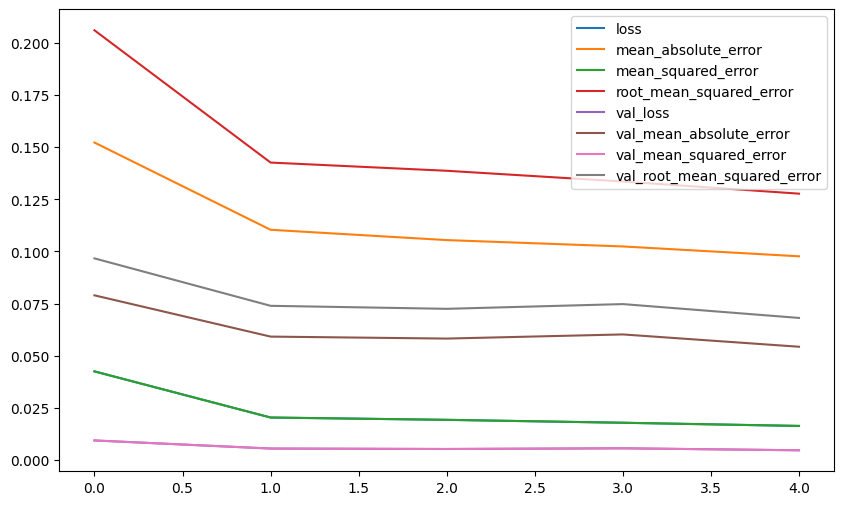

In [60]:
loss.plot(figsize = (10,6))

In [61]:
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (model1.metrics_names[0], scores[0]*100))
# print("%s: %.2f%%" % (model1.metrics_names[1], scores[1]*100))